# debug firmware
This notebook uses a special firmware which doesn't have a tProcessor (so you can't run regular QICK programs, readout is less efficient, and interfaces are clunkier), but wires all DACs and ADCs and reads out through a full-speed (not decimated) buffer.

We can use this to get power spectra at the ADCs and check for spurs.

This notebook (and all notebooks in this directory) was run in loopback with 26 dB of external attenuation: 16 dB estimated end-to-end attenuation in the Run 14 NEXUS setup, and 10 dB additional pad.

In [1]:
# from test_rfboard_dr import *
from qick.rfboard import *

from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Test(RFQickSocV2):
    def __init__(self, bitfile=None, force_init_clks=True, ignore_version=True, **kwargs):
        """
        By default, re-initialize the clocks every time.
        This ensures that the LO output to the RF board is enabled.
        """
        super().__init__(bitfile=bitfile, force_init_clks=force_init_clks, ignore_version=ignore_version, no_tproc=True, **kwargs)
        
        self.switch_gen = self.axis_dds_mr_switch_0
        
        # Signal Generators.
        self.gen = [getattr(self, "axis_signal_gen_v3_%d"%(i)) for i in range(8)]
        for i, gen in enumerate(self.gen):
            gen.config(self.axi_dma_0, self.axis_dds_mr_switch_0, self.axis_switch_0, i, "DAC")
                
        # Signal Generators Control.
        self.gen_ctrl = [getattr(self, "axis_signal_gen_v3_c_%d"%(i)) for i in range(8)]
        for i, dac in enumerate(self.dacs): dac.gen_ctrl = self.gen_ctrl[i]
        
        # Buffer for ADC channels.
        self.switch_buf = self.axis_switch_1
        self.buf = self.mr_buffer_et_0
        self.buf.config(self.axi_dma_1,self.switch_buf)

        def capture(self):
            self.switch.sel(slv=self.ch)
            time.sleep(0.1)
            self.buf.enable()
            time.sleep(0.1)
            self.buf.disable()
        def transfer(self, buff):
            self.buf.transfer(buff)
        for i, adc in enumerate(self.adcs):
            adc.switch = self.switch_buf
            adc.buf = self.buf
            adc.capture = capture.__get__(adc, adc.__class__)
            adc.transfer = transfer.__get__(adc, adc.__class__)

In [3]:
# Load bitstream with custom overlay
# soc = PfbSoc('../test_rfboard.bit',init_clks=True, ignore_version=True)
#soc = RFQickSocV2('test_rfboard_v2.bit')
soc = Test('test_rfboard_v2.bit')

# Sampling frequency of ADC/DAC.
#fs_adc = 8*384
#fs_dac = 16*256
fs_adc = 3072
fs_dac = 6144

# Set sampling frequency of controller.
for i in range(8): soc.gen_ctrl[i].set_fs(fs_dac)
for i in range(8): soc.gen_ctrl[i].add(freq=200,gain=0)
    
# Define receive buffer for Full-Speed data.
buff = allocate(shape=(soc.buf.MAX_LENGTH), dtype=np.int16)

resetting clocks: 204.8


In [4]:
# darkfreq800 = [6.18807, 5.8285, 6.075045, 5.95940] # Best for 800 gain
# qubitresPulse = [4.800, 4.6571, 4.4928, 4.6518]

hw_cfg={"res_ch":6, # RF board channel indexing (not tProc)
        "qubit_ch":2,
        "ro_ch":1,
        "f_res":5828.5,
        "f_ge": 4657.1
       }

rfb_cfg={"f_lo_ro":122.88*56,
         "f_lo_qubit":122.88*28,
        "att_res":(0,14.5),
        "att_qubit":(0,16),
         "att_ro":30
       }
# f_lo_ro = 122.88*56 # 6881
# f_lo_qubit = 122.88*28 # 3441

soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.dacs[hw_cfg['res_ch']].set_rf(att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.adcs[hw_cfg['ro_ch']].set_attn_db(rfb_cfg['att_ro'])

meas_cfg={"res_gain":800,
    "if_res": abs(rfb_cfg['f_lo_ro'] - hw_cfg['f_res']), # MHz, start value
    "if_ge": abs(rfb_cfg['f_lo_qubit'] - hw_cfg['f_ge']), # MHz, start value
          "nqz":1,
          "qubit_gain":19500
       }

print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   2 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  6881.28 |    0.00 | 2.2400e+02

Choosing solution 0 with minimal metric 224.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 13762.56 |   4 |       2 |  112 |  False |    1 |    1 |     1 |  122.88 |  3440.64 |    0.00 | 4.4800e+02

Choosing solution 0 with minimal metric 448.
lock attempt 1 failed
LO locked on attempt 2 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|---------

In [5]:
print([lo.is_locked() for lo in soc.lo])
print([lo.freq for lo in soc.lo])

[True, True, True]
[6881.28, 3440.64, 6881.28]


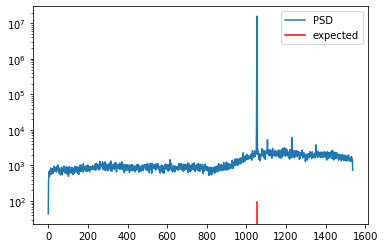

In [11]:
# normal readout config
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_res'],gain=meas_cfg['res_gain'])

time.sleep(0.1)
# Capture data on adc.
soc.adcs[hw_cfg['ro_ch']].capture()
# Transfer
soc.adcs[hw_cfg['ro_ch']].transfer(buff=buff)

# back to normal
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=200,gain=0)

fft_freqs, psd = welch(buff, fs_adc, nperseg=4096)
plt.semilogy(fft_freqs, psd, label='PSD')
plt.axvline(meas_cfg['if_res'], label="expected",color='r', ymin=0,ymax=0.1)
plt.legend()

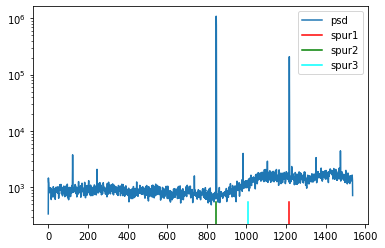

In [12]:
# configure DAC for qubit drive and ADC for readout, to see if we have any interesting spurs on qubit drive
# we need to reduce the power a lot, so as not to overdrive the ADC
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=2) # DACs 4-7
# soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_ge'],gain=meas_cfg['qubit_gain'])
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_ge'],gain=1000)
soc.dacs[hw_cfg['res_ch']].set_rf(att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])

time.sleep(0.1)
# Capture data on adc.
soc.adcs[hw_cfg['ro_ch']].capture()
# Transfer
soc.adcs[hw_cfg['ro_ch']].transfer(buff=buff)

# back to normal
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=1) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2) # DACs 4-7
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=200,gain=0)
soc.dacs[hw_cfg['res_ch']].set_rf(att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])

fft_freqs, psd = welch(buff, fs_adc, nperseg=4096)
plt.semilogy(fft_freqs, psd, label='psd')
# qubit drive mixed with readout LO?
plt.axvline(meas_cfg['if_ge'], label="spur1",color='r', ymin=0,ymax=0.1)
# lower sideband, RF->IF leakage, getting past the IF low-pass filter and into 2nd nyquist?
plt.axvline(meas_cfg['if_ge']-(rfb_cfg['f_lo_qubit']-fs_adc), label="spur2",color='g', ymin=0,ymax=0.1)
# 2x IF (distortion maybe), mixed up with 2x LO and mixed down with 1/2 LO?
plt.axvline(rfb_cfg['f_lo_qubit']-2*meas_cfg['if_ge'], label="spur3", color='aqua', ymin=0,ymax=0.1)

plt.legend()

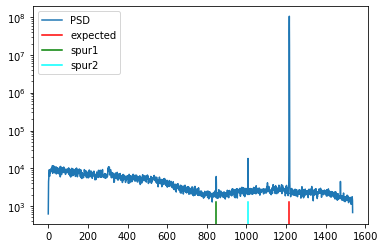

In [13]:
# configure DAC for qubit drive and ADC for qubit drive
# we need to reduce the power a lot, so as not to overdrive the ADC

soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=0) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=2) # DACs 4-7
# soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_ge'],gain=meas_cfg['qubit_gain'])
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_ge'],gain=1000)
soc.dacs[hw_cfg['res_ch']].set_rf(att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])

time.sleep(0.1)
# Capture data on adc.
soc.adcs[hw_cfg['ro_ch']].capture()
# Transfer
soc.adcs[hw_cfg['ro_ch']].transfer(buff=buff)

# back to normal
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=1) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2) # DACs 4-7
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=200,gain=0)
soc.dacs[hw_cfg['res_ch']].set_rf(att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])

fft_freqs, psd = welch(buff, fs_adc, nperseg=4096)
plt.semilogy(fft_freqs, psd, label='PSD')
plt.axvline(meas_cfg['if_ge'], label="expected",color='r', ymin=0,ymax=0.1)
# nyquist image of RF->IF leakage, getting past the low-pass filter??
plt.axvline(meas_cfg['if_ge']-(rfb_cfg['f_lo_qubit']-fs_adc), label="spur1",color='g', ymin=0,ymax=0.1)
# 2x IF (distortion) mixing with 2*LO? visible on spectrum analyzer at 4.44 GHz
plt.axvline(rfb_cfg['f_lo_qubit']-2*meas_cfg['if_ge'], label="spur2", color='aqua', ymin=0,ymax=0.1)

plt.legend()

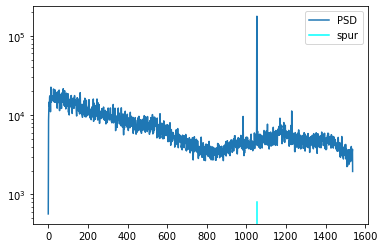

In [14]:
# configure DAC for readout drive and ADC for qubit drive
# this should tell us if the readout DAC drives any power at qubit frequencies

soc.rfb_set_lo(rfb_cfg['f_lo_qubit'], ch=0) # ADCs
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=meas_cfg['if_res'],gain=meas_cfg['res_gain'])

time.sleep(0.1)
# Capture data on adc.
soc.adcs[hw_cfg['ro_ch']].capture()
# time.sleep(0.1)
# Transfer
soc.adcs[hw_cfg['ro_ch']].transfer(buff=buff)
# time.sleep(0.1)

# back to normal
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0) # ADCs
soc.dacs[hw_cfg['res_ch']].gen_ctrl.add(freq=200,gain=0)

fft_freqs, psd = welch(buff, fs_adc, nperseg=4096)
plt.semilogy(fft_freqs, psd, label='PSD')
# IF-RF leakage?
plt.axvline(meas_cfg['if_res'], label="spur",color='aqua', ymin=0,ymax=0.1)


plt.legend()

In [10]:
# scratchwork below

In [ ]:
# Sweep LO and first attenuator.
lo_f = np.linspace(start=4000, stop=8000, num=10)
db = np.linspace(start=0, stop=30, num=50)
for i in range(len(lo_f)):
    # Set LO frequency.
    soc.lo[1].set_freq(lo_f[i])
    for j in range(len(db)):
        #print("LO = %f MHz, ATT[1] = %f dB" %(lo_f[i],db[j]))
        soc.dacs[6].attn[0].set_att(db[j])
        soc.dacs[7].attn[0].set_att(db[j])
        time.sleep(0.1)

In [ ]:
# Sweep LO.
soc.dacs[6].attn[0].set_att(0)
soc.dacs[6].attn[1].set_att(14)
soc.dacs[7].attn[0].set_att(0)
lo_f = np.linspace(start=7000, stop=8000, num=50)
for i in range(len(lo_f)):
    # Set LO frequency.
    soc.lo[1].set_freq(lo_f[i])
    time.sleep(1)

In [ ]:
soc.dacs[2].gen_ctrl.add(freq=1800,gain=5000)
soc.dacs[2].attn[0].set_att(10)
soc.dacs[2].attn[1].set_att(10)
soc.dacs[2].rfsw_sel("DC")

In [ ]:
for i in range(30):
    soc.dacs[3].set_attn_db(0,0)
    time.sleep(1)

In [ ]:
soc.lo[0].set_freq(4000)
soc.dacs[2].gen_ctrl.add(freq=100,gain=25000)
soc.dacs[3].gen_ctrl.add(freq=100,gain=25000)
soc.dacs[2].attn[0].set_att(0)
soc.dacs[2].attn[1].set_att(10)
soc.dacs[3].attn[0].set_att(0)
soc.dacs[3].attn[1].set_att(10)
soc.dacs[2].rfsw_sel("RF")
soc.dacs[3].rfsw_sel("RF")

In [ ]:
soc.dacs[7].set_attn_db(0,10)
soc.dacs[7].set_attn_db(1,20)
#soc.adcs[0].set_attn_db(30)

In [ ]:
soc.adcs

In [ ]:
soc.dacs[0]

In [ ]:
soc.buf.enable()

In [ ]:
soc.buf.disable()

In [ ]:
fs_adc = 3072
fs_dac = 6144

In [ ]:
fs_adc,fs_dac

In [ ]:
# Enable DC outputs
soc.dac_pwr.bits_reset(bits=[0,1,2,3,4,5,6,7],dev_addr=1)

In [ ]:
# Disable DC outputs
soc.dac_pwr.bits_set(bits=[0,1,2,3,4,5,6,7],dev_addr=1)

In [ ]:
# Enable RF outputs
soc.dac_pwr.bits_set(bits=[0,1,2,3,4,5,6,7],dev_addr=0)

In [ ]:
# Disable RF outputs
soc.dac_pwr.bits_reset(bits=[0,1,2,3,4,5,6,7],dev_addr=0)

In [ ]:
# Enable DC-Coupled ADC Inputs.
soc.adc_pwr.bits_reset(bits=[4,5,6,7])

In [ ]:
# Disable DC-Coupled ADC Inputs.
soc.adc_pwr.bits_set(bits=[4,5,6,7])

In [ ]:
# Enable RF ADC Inputs.
soc.adc_pwr.bits_set(bits=[0,1,2,3])

In [ ]:
# Disable RF ADC Inputs.
soc.adc_pwr.bits_reset(bits=[0,1,2,3])

In [ ]:
# Set DAC Output Switch
for i in range(8):
    soc.dacs[i].rfsw_sel("DC")

In [ ]:
# Set frequency.
for i in range(8):
    #soc.dacs[i].gen_ctrl.add(freq=500,gain=32000)
    soc.gen_ctrl[i].add(freq=100,gain=32000)
    soc.dacs[i].rfsw_sel("DC")

In [ ]:
# Set DAC Output Switch
for i in range(8):
    soc.dacs[i].rfsw_sel("RF")

In [ ]:
# One tone on each channel.
for i in range(8):
    #soc.dacs[i].gen_ctrl.add(freq=1000,gain=15000)
    soc.gen_ctrl[i].add(freq=1000,gain=32000)
    soc.dacs[i].rfsw_sel("RF")

In [ ]:
# use the fancy ipq thing
for lo in soc.lo:
    lo.reset()
    lo.set_freq(122.88*62,pwr=31)

In [ ]:
# One tone on each channel.
for i in range(8):
    soc.dacs[i].gen_ctrl.add(freq=1000,gain=30000)
#     soc.gen_ctrl[i].add(freq=0,gain=0)
    soc.dacs[i].rfsw_sel("RF")
    soc.dacs[i].attn[0].set_att(20)
    soc.dacs[i].attn[1].set_att(31.75)

In [ ]:
soc.buf.route(2)
soc.buf.capture()
x = soc.buf.transfer()
max(x)

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(x)
plt.xlim([500,1000])

In [ ]:
w = sp.hanning(len(x))
xw = x*w
F = (np.arange(len(x))/len(x)-0.5)*fs_adc
Y = sp.fftpack.fftshift(sp.fft(xw))
Y = abs(Y)
plt.figure(figsize=(16,5))
#plt.figure(1,dpi=100)
plt.plot(F,20*np.log10(Y/np.max(Y)))

In [ ]:
w = sp.hanning(len(x))
xw = x*w
F = (np.arange(len(x))/len(x)-0.5)*fs_adc
Y = sp.fftpack.fftshift(sp.fft(xw))
Y = abs(Y/len(x))
plt.figure(figsize=(16,5))
#plt.figure(1,dpi=100)
plt.plot(F,20*np.log10(Y))

In [ ]:
soc.adcs[4].set_gain_db(db=-6)

In [ ]:
soc.adcs[1].set_attn_db(30)

In [ ]:
fs_adc/len(x)

In [ ]:
fs_adc

In [ ]:
# Save data to file.
fn = "data.mat"
sio.savemat(fn,{'xi':x})

print("Written file " + fn)

In [ ]:
# Program DAC attenuators.
chan=5
soc.dacs[chan].attn[0].set_att(31.75)
soc.dacs[chan].attn[1].set_att(31.75)

In [ ]:
# Sweep attenuator.
chan = 5
att = 0
for i in np.linspace(start=0,stop=30, num=10):
    soc.dacs[chan].attn[att].set_att(i)
    time.sleep(2)

In [ ]:
# Program ADC attenuator.
soc.adcs[3].set_attn_db(31)